# Resale Prices Working File

In [210]:
import requests
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats
from tqdm.notebook import trange

In [5]:
pd.set_option('display.width', 300)
pd.set_option('display.max_columns', 10)

# os.chdir('D:/User/Documents/R/Github/Portfolio/hdb_resale_prices/')
os.chdir('C:/Users/thela/Documents/Github/Portfolio/hdb_resale_prices/')

In [127]:
def onemap_geocoding(address):
    result = requests.get('https://developers.onemap.sg/commonapi/search?searchVal='+address+'&returnGeom=Y&getAddrDetails=Y&pageNum=1')
    result = eval(result.text)
    
    if result['found'] > 0:
        lat, long = result['results'][0]['LATITUDE'], result['results'][0]['LONGITUDE']
        return address, lat, long
    else:
        pass

def onemap_geocoding_flat(address):
    result = requests.get('https://developers.onemap.sg/commonapi/search?searchVal='+address+'&returnGeom=Y&getAddrDetails=Y&pageNum=1')
    result = eval(result.text)
    
    if result['found'] > 0:
        for i in result['results']:
            lat, long = i['LATITUDE'], i['LONGITUDE']
            r_block, r_street = i['BLK_NO'], i['ROAD_NAME']
            r_add = r_block + ' ' + r_street
            
            if r_add == address:
                return address, r_add, lat, long
            else:
                continue
        return address, 'none', '0', '0'
    else:
        pass
    
def geocode_series(addresses, func):
    coord_list = []
    failed_list = []
    failed = 0
    t = trange(len(addresses), desc='Geoding Addresses')
    for i in t:
        try:
            result = func(addresses[i])
            if len(result) > 0:
                coord_list.append(result)
                t.set_description('{} failed'.format(failed))
        except Exception as e:
            print(e)
            failed_list.append(addresses[i])
            failed += 1
            t.set_description('{} failed'.format(failed))
    print(failed_list if failed_list else "All passed")
    return coord_list

def calculate_dist(address_df, dist_df, date_check=False):
    temp = address_df.copy()
    t = trange(len(dist_df), desc='Feature Distance Calculation')
    for _, i in dist_df.iterrows():
        name, lat, long = i[0], float(i[1]), float(i[2])
        distances = (((address_df['latitude'] - lat) * 110.574) ** 2 + ((address_df['longitude'] - long) * 111.32) ** 2) ** 0.5
        if date_check:
            check_date = i[3]
            exists = (address_df['sale_year'] > check_date.year) | ((address_df['sale_year'] > check_date.year) & (address_df['sale_month'] >= check_date.month))
            distances = pd.concat([distances, exists], axis=1).apply(lambda x: x[0] if x[1] else float("inf"), axis=1)
        temp = pd.concat([temp, distances.rename(name)], axis=1)
        t.update(1)
    nearest_name = temp.drop(['address', 'longitude', 'latitude', 'month', 'sale_year', 'sale_month'], axis=1).idxmin(axis=1)
    nearest_dist = temp.drop(['address', 'longitude', 'latitude', 'month', 'sale_year', 'sale_month'], axis=1).min(axis=1)
    nearest = pd.concat([temp[['address', 'month']], nearest_name, nearest_dist], axis=1)
    return nearest

# test = calculate_dist(resale_df, mrt_coord_df)

def calculate_pri_score(address_df, dist_list, rank_list, dist_cutoff, num_cutoff, dist_weights={1: 0.1, 2: 0.5, 999: 1}):
    temp = address_df.copy()
    for i in dist_list:
        name, lat, long = i[0], float(i[1]), float(i[2])
        rank = int(rank_list.loc[rank_list['pri_sch_name'] == name]['rank'])
        temp[str(rank)] = (((address_df['latitude'] - lat) * 110.574) ** 2 + ((address_df['longitude'] - long) * 111.32) ** 2) ** 0.5
        
    t = trange(len(temp), desc='Address')
    distances = temp.drop(['address', 'latitude', 'longitude'], axis=1)
    result = {}
    for i in t:
        row = distances.iloc[i]
        row = row[row <= dist_cutoff][:num_cutoff]
        
        score = 0
        for j in row.index:
            dist = row[j]
            for ring in dist_weights.keys():
                if dist < ring:
                    weight = dist_weights[ring]
                    break
            score += (weight * int(j))

        result[temp.iloc[i]['address']] = score if score != 0 else 9999
        
    result = pd.DataFrame.from_dict(result, orient='index', columns=['pri_sch_score'])
    return result

## Dataset

Importing resale prices from data.gov API

In [ ]:
dataset = requests.get('https://data.gov.sg/api/action/datastore_search?resource_id=f1765b54-a209-4718-8d38-a39237f502b3&limit=9999999').json()
resale_df = pd.DataFrame(dataset['result']['records'])
resale_df.to_csv('data/resale_df_raw.csv', index=False)

In [7]:
resale_df = pd.read_csv('data/resale_df_raw.csv')

In [8]:
resale_df.head()

,town,flat_type,flat_model,floor_area_sqm,street_name,...,remaining_lease,lease_commence_date,storey_range,_id,block
0,ANG MO KIO,2 ROOM,Improved,44.0,ANG MO KIO AVE 10,...,61 years 04 months,1979,10 TO 12,1,406
1,ANG MO KIO,3 ROOM,New Generation,67.0,ANG MO KIO AVE 4,...,60 years 07 months,1978,01 TO 03,2,108
2,ANG MO KIO,3 ROOM,New Generation,67.0,ANG MO KIO AVE 5,...,62 years 05 months,1980,01 TO 03,3,602
3,ANG MO KIO,3 ROOM,New Generation,68.0,ANG MO KIO AVE 10,...,62 years 01 month,1980,04 TO 06,4,465
4,ANG MO KIO,3 ROOM,New Generation,67.0,ANG MO KIO AVE 5,...,62 years 05 months,1980,01 TO 03,5,601


Getting search fields for geocoding

In [9]:
resale_df['address'] = resale_df['block'] + ' ' + resale_df['street_name']
# resale_df['address'] = resale_df['address'].str.replace('ST. GEORGE', 'SAINT GEORGE')

changes = [[r'\bAVE\b', 'AVENUE'],
           [r'\bRD\b', 'ROAD'],
           [r'\bNTH\b', 'NORTH'],
           [r'\bSTH\b', 'SOUTH'],
           [r'\bST\. GEORGE\b', 'SAINT GEORGE'],
           [r'\bST\b', 'STREET'],
           [r'\bCTRL\b', 'CENTRAL'],
           [r'\bDR\b', 'DRIVE'],
           [r'\bBT\b', 'BUKIT'],
           [r'\bJLN\b', 'JALAN'],
           [r'\bCRES\b', 'CRESCENT'],
           [r'\bLOR\b', 'LORONG'],
           [r"\bC'WEALTH\b", 'COMMONWEALTH'],
           [r'\bCL\b', 'CLOSE'],
           [r'\bGDNS\b', 'GARDENS'],
           [r'\bUPP\b', 'UPPER'],
           [r'\bHTS\b', 'HEIGHTS'],
           [r'\bTER\b', 'TERRACE'],
           [r'\bPL\b', 'PLACE'],
           [r'\bTG\b', 'TANJONG'],
           [r'\bPK\b', 'PARK'],
           [r'\bMKT\b', 'MARKET'],
           [r'\bKG\b', 'KAMPONG']]
for short, long in changes:
    resale_df['address'] = resale_df['address'].str.replace(short, long, regex=True)

Geocoding address with OneMap API

In [14]:
house_addresses = resale_df['address'].unique()
coord_list = geocode_series(house_addresses, onemap_geocoding_flat)
coord_df = pd.DataFrame(coord_list, columns=['address', 'search_address', 'latitude', 'longitude'])

Geoding Addresses:   0%|          | 0/9459 [00:00<?, ?it/s]

All passed


In [15]:
coord_df[coord_df['search_address'] == 'null']

,address,search_address,latitude,longitude


In [16]:
none_check = coord_df.isnull().sum()
none_check

address           0
search_address    0
latitude          0
longitude         0
dtype: int64

In [17]:
cck_exception = eval(requests.get('https://developers.onemap.sg/commonapi/search?searchVal=BLK 216 AND 215 CHOA CHU KANG CENTRAL&returnGeom=Y&getAddrDetails=Y&pageNum=1').text)['results'][0]
for idx in coord_df[coord_df['search_address'] == 'none'].index:
    coord_df.loc[idx]['latitude'] = cck_exception['LATITUDE']
    coord_df.loc[idx]['longitude'] = cck_exception['LONGITUDE']

In [18]:
coord_df[['latitude','longitude']] = coord_df[['latitude', 'longitude']].astype(float)
coord_df.drop('search_address', axis=1, inplace=True)

In [19]:
resale_df = resale_df.merge(right=coord_df, on='address', how='left')
resale_map_df = resale_df[['address', 'month', 'latitude', 'longitude']]
resale_map_df['sale_year'] = resale_map_df['month'].str[:4].astype(int)
resale_map_df['sale_month'] = resale_map_df['month'].str[5:7].astype(int)

C:\Users\thela\AppData\Local\Temp\ipykernel_9056\3417726555.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  resale_map_df['sale_year'] = resale_map_df['month'].str[:4].astype(int)
C:\Users\thela\AppData\Local\Temp\ipykernel_9056\3417726555.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  resale_map_df['sale_month'] = resale_map_df['month'].str[5:7].astype(int)


In [20]:
resale_map_df.head()

,address,month,latitude,longitude,sale_year,sale_month
0,406 ANG MO KIO AVENUE 10,2017-01,1.362005,103.853880,2017,1
1,108 ANG MO KIO AVENUE 4,2017-01,1.370943,103.837975,2017,1
2,602 ANG MO KIO AVENUE 5,2017-01,1.380709,103.835368,2017,1
3,465 ANG MO KIO AVENUE 10,2017-01,1.366201,103.857201,2017,1
4,601 ANG MO KIO AVENUE 5,2017-01,1.381041,103.835132,2017,1


In [ ]:
resale_df.to_csv('data/resale_df_geocode.csv', index=False)

## MRT Stations

In [21]:
mrt_df = pd.read_csv('data\mrt_stations.csv').query('is_active == "Y"')
mrt_df['commence_date'] = pd.to_datetime(mrt_df['commence_date'], format='%Y-%m-%d')

In [22]:
mrt_df.head()

,stn_id,line_id,stn_name,commence_date,is_active
0,BP1,BPLRT,CHOA CHU KANG LRT STATION,1999-11-06,Y
1,BP2,BPLRT,SOUTH VIEW LRT STATION,1999-11-06,Y
2,BP3,BPLRT,KEAT HONG LRT STATION,1999-11-06,Y
3,BP4,BPLRT,TECK WHYE LRT STATION,1999-11-06,Y
4,BP5,BPLRT,PHOENIX LRT STATION,1999-11-06,Y


Geocoding MRT stations

In [24]:
mrt_names = mrt_df['stn_name'].unique()
mrt_coord = geocode_series(mrt_names, onemap_geocoding)
mrt_coord_df = pd.DataFrame(mrt_coord, columns = ['stn_name', 'latitude', 'longitude'])
mrt_coord_df[['latitude', 'longitude']] = mrt_coord_df[['latitude', 'longitude']].astype(float)
mrt_coord_df = mrt_df.merge(right=mrt_coord_df, on='stn_name', how='left')

Geoding Addresses:   0%|          | 0/175 [00:00<?, ?it/s]

All passed


In [26]:
none_check = mrt_coord_df.isnull().sum()
none_check

stn_id           0
line_id          0
stn_name         0
commence_date    0
is_active        0
latitude         0
longitude        0
dtype: int64

In [29]:
mrt_coord_df_test = mrt_coord_df[['stn_name', 'latitude', 'longitude', 'commence_date']]
mrt_coord_df_test

,stn_name,latitude,longitude,commence_date
0,CHOA CHU KANG LRT STATION,1.384755,103.744538,1999-11-06
1,SOUTH VIEW LRT STATION,1.380298,103.745292,1999-11-06
2,KEAT HONG LRT STATION,1.378603,103.749056,1999-11-06
3,TECK WHYE LRT STATION,1.376685,103.753712,1999-11-06
4,PHOENIX LRT STATION,1.378615,103.757996,1999-11-06
...,...,...,...,...
198,OUTRAM PARK MRT STATION,1.279740,103.839514,2022-11-13
199,MAXWELL MRT STATION,1.280533,103.843884,2022-11-13
200,SHENTON WAY MRT STATION,1.277717,103.850368,2022-11-13
201,MARINA BAY MRT STATION,1.276427,103.854598,2022-11-13


In [129]:
mrt_dist_df = calculate_dist(resale_map_df, mrt_coord_df_test, date_check='commence_date')

Feature Distance Calculation:   0%|          | 0/203 [00:00<?, ?it/s]

In [135]:
mrt_dist_df

,address,month,0,1
0,406 ANG MO KIO AVENUE 10,2017-01,ANG MO KIO MRT STATION,0.957337
1,108 ANG MO KIO AVENUE 4,2017-01,ANG MO KIO MRT STATION,1.288919
2,602 ANG MO KIO AVENUE 5,2017-01,YIO CHU KANG MRT STATION,1.076611
3,465 ANG MO KIO AVENUE 10,2017-01,ANG MO KIO MRT STATION,0.933192
4,601 ANG MO KIO AVENUE 5,2017-01,YIO CHU KANG MRT STATION,1.099826
...,...,...,...,...
155075,291 YISHUN STREET 22,2023-06,YISHUN MRT STATION,0.724306
155076,513B YISHUN STREET 51,2023-06,KHATIB MRT STATION,1.201740
155077,511B YISHUN STREET 51,2023-06,KHATIB MRT STATION,1.068567
155078,791 YISHUN AVENUE 2,2023-06,KHATIB MRT STATION,0.352857


Check difference in stations due to commence date

In [130]:
mrt_dist_df_2 = calculate_dist(resale_map_df, mrt_coord_df_test)

Feature Distance Calculation:   0%|          | 0/203 [00:00<?, ?it/s]

In [198]:
mrt_dist_df_2

,address,month,nearest_mrt_2,nearest_mrt_dist_2
0,406 ANG MO KIO AVENUE 10,2017-01,ANG MO KIO MRT STATION,0.957337
1,108 ANG MO KIO AVENUE 4,2017-01,MAYFLOWER MRT STATION,0.166871
2,602 ANG MO KIO AVENUE 5,2017-01,LENTOR MRT STATION,0.532151
3,465 ANG MO KIO AVENUE 10,2017-01,ANG MO KIO MRT STATION,0.933192
4,601 ANG MO KIO AVENUE 5,2017-01,LENTOR MRT STATION,0.498417
...,...,...,...,...
155075,291 YISHUN STREET 22,2023-06,YISHUN MRT STATION,0.724306
155076,513B YISHUN STREET 51,2023-06,KHATIB MRT STATION,1.201740
155077,511B YISHUN STREET 51,2023-06,KHATIB MRT STATION,1.068567
155078,791 YISHUN AVENUE 2,2023-06,KHATIB MRT STATION,0.352857


In [180]:
check = pd.concat([mrt_dist_df, mrt_dist_df_2], axis=1)
check.columns.values[:8]=['add1','month1','mrt1','dist1','add2','month2','mrt2','dist2']
check['add_check'] = check.apply(lambda x: x['add1'] == x['add2'], axis=1)
check['mrt_check'] = check.apply(lambda x: x['mrt1'] == x['mrt2'], axis=1)

In [182]:
check[check['mrt_check']==False]

,add1,month1,mrt1,dist1,add2,month2,mrt2,dist2,add_check,mrt_check
1,108 ANG MO KIO AVENUE 4,2017-01,ANG MO KIO MRT STATION,1.288919,108 ANG MO KIO AVENUE 4,2017-01,MAYFLOWER MRT STATION,0.166871,True,False
2,602 ANG MO KIO AVENUE 5,2017-01,YIO CHU KANG MRT STATION,1.076611,602 ANG MO KIO AVENUE 5,2017-01,LENTOR MRT STATION,0.532151,True,False
4,601 ANG MO KIO AVENUE 5,2017-01,YIO CHU KANG MRT STATION,1.099826,601 ANG MO KIO AVENUE 5,2017-01,LENTOR MRT STATION,0.498417,True,False
7,218 ANG MO KIO AVENUE 1,2017-01,ANG MO KIO MRT STATION,0.981953,218 ANG MO KIO AVENUE 1,2017-01,BRIGHT HILL MRT STATION,0.884375,True,False
11,233 ANG MO KIO AVENUE 3,2017-01,ANG MO KIO MRT STATION,1.430562,233 ANG MO KIO AVENUE 3,2017-01,MAYFLOWER MRT STATION,0.433207,True,False
...,...,...,...,...,...,...,...,...,...,...
141596,10 JALAN KUKOH,2022-12,CHINATOWN MRT STATION,0.740770,10 JALAN KUKOH,2022-12,HAVELOCK MRT STATION,0.634171,True,False
141597,8 JALAN KUKOH,2022-12,CHINATOWN MRT STATION,0.727621,8 JALAN KUKOH,2022-12,HAVELOCK MRT STATION,0.659905,True,False
141599,9 JALAN KUKOH,2022-12,CHINATOWN MRT STATION,0.796995,9 JALAN KUKOH,2022-12,HAVELOCK MRT STATION,0.594035,True,False
141600,9 JALAN KUKOH,2022-12,CHINATOWN MRT STATION,0.796995,9 JALAN KUKOH,2022-12,HAVELOCK MRT STATION,0.594035,True,False


Adding interchanges as a feature

In [269]:
mrt_interchange = mrt_coord_df_test.groupby('stn_name', as_index=False).size()
mrt_interchange[mrt_interchange['size']>1]

,stn_name,size
6,BAYFRONT MRT STATION,2
13,BISHAN MRT STATION,2
16,BOTANIC GARDENS MRT STATION,2
21,BUGIS MRT STATION,2
26,BUONA VISTA MRT STATION,2
27,CALDECOTT MRT STATION,2
32,CHINATOWN MRT STATION,2
36,CITY HALL MRT STATION,2
45,DHOBY GHAUT MRT STATION,3
50,EXPO MRT STATION,2


Merging MRT stations back to main dataframe

In [183]:
mrt_dist_df.columns = ['address', 'month', 'nearest_mrt', 'nearest_mrt_dist']
resale_df = resale_df.merge(mrt_dist_df, on=['address', 'month'], how='left')

In [185]:
mrt_dist_df_2.columns = ['address', 'month', 'nearest_mrt_2', 'nearest_mrt_dist_2']
resale_df = resale_df.merge(mrt_dist_df_2, on=['address', 'month'], how='left')

In [270]:
resale_df = resale_df.merge(mrt_interchange, left_on='nearest_mrt', right_on='stn_name', how='left')

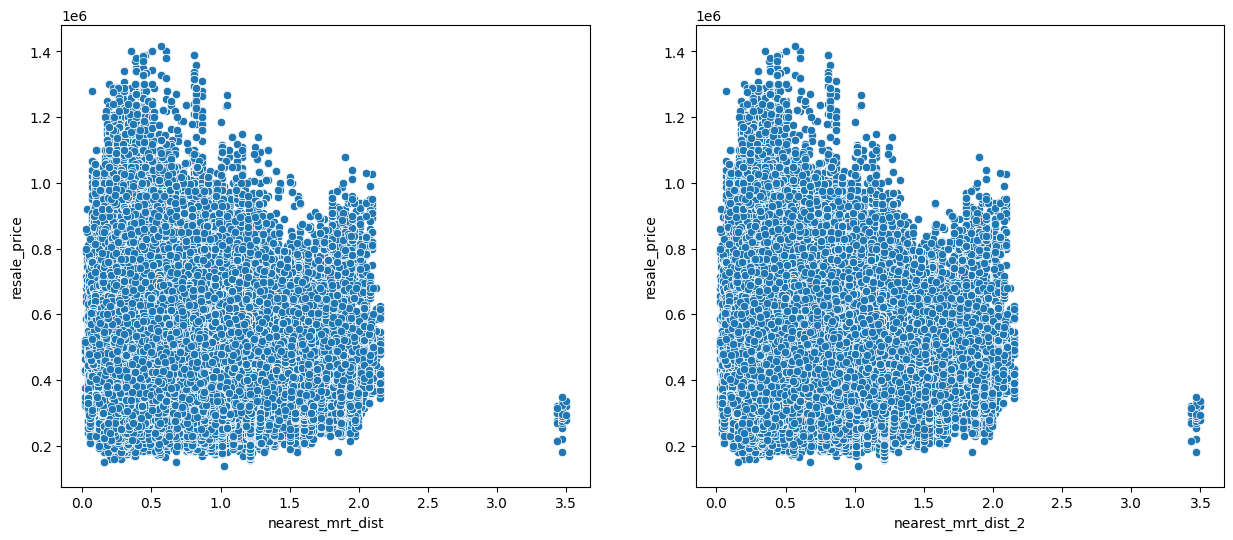

In [189]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15,6))

_ = sns.scatterplot(data=resale_df, x='nearest_mrt_dist', y='resale_price', ax=axs[0])
_ = sns.scatterplot(data=resale_df, x='nearest_mrt_dist_2', y='resale_price', ax=axs[1])

In [230]:
bins = pd.IntervalIndex.from_tuples([(0,0.5), (0.5,1), (1,4)])
resale_df['nearest_mrt_dist_cut'] = pd.cut(resale_df['nearest_mrt_dist'], bins)
resale_df['nearest_mrt_dist_2_cut'] = pd.cut(resale_df['nearest_mrt_dist_2'], bins)

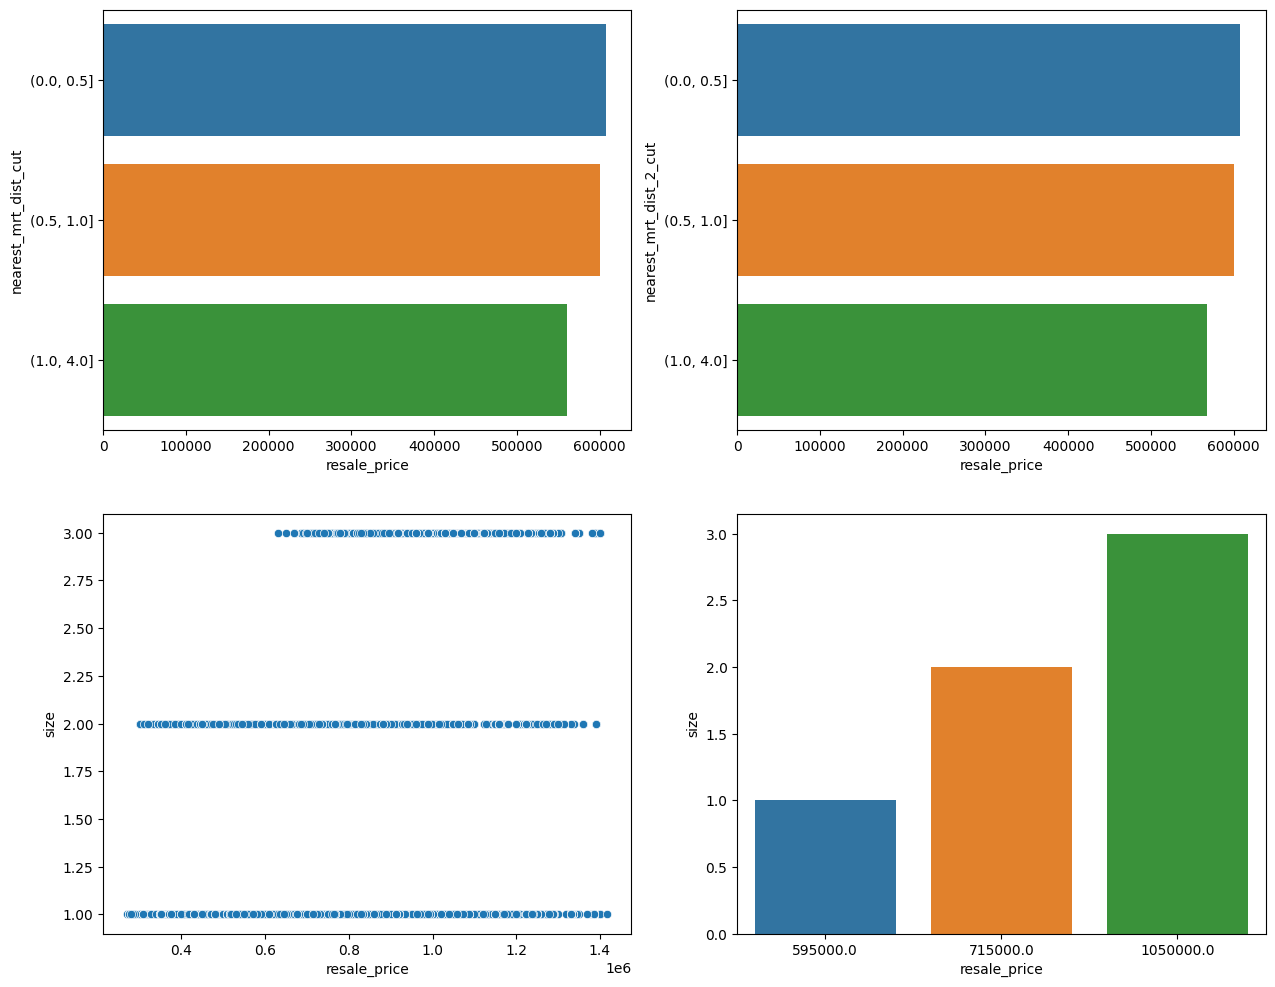

In [287]:
temp_df = resale_df.copy()[resale_df['flat_type'] == '5 ROOM']
temp_df_1 = temp_df.groupby('nearest_mrt_dist_cut', as_index=False)['resale_price'].median()
temp_df_2 = temp_df.groupby('nearest_mrt_dist_2_cut', as_index=False)['resale_price'].median()
temp_df_3 = temp_df.groupby('size', as_index=False)['resale_price'].median()

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15,12))
_ = sns.barplot(data=temp_df_1, x='resale_price', y='nearest_mrt_dist_cut', ax=axs[0][0])
_ = sns.barplot(data=temp_df_2, x='resale_price', y='nearest_mrt_dist_2_cut', ax=axs[0][1])
_ = sns.scatterplot(data=temp_df, x='resale_price', y='size', ax=axs[1][0])
_ = sns.barplot(data=temp_df_3, x='resale_price', y='size', ax=axs[1][1])

In [221]:
scipy.stats.pearsonr(resale_df['nearest_mrt_dist'], resale_df['resale_price'])
scipy.stats.spearmanr(resale_df['nearest_mrt_dist'], resale_df['resale_price'])

SpearmanrResult(correlation=-0.15129611102536278, pvalue=0.0)

In [288]:
scipy.stats.spearmanr(resale_df['size'], resale_df['resale_price'])

SpearmanrResult(correlation=0.0811337456907804, pvalue=0.0)

In [285]:
feature = resale_df['nearest_mrt_dist']/(resale_df['size']**2)
scipy.stats.spearmanr(feature, resale_df['resale_price'])

SpearmanrResult(correlation=-0.16513935381892023, pvalue=0.0)